## Combining DEA with external sources of data.

#### As you have probably noticed, satellite images often contain clouds. Detecting and filtering these clouds is a non-trivial task. Clouds appear in all sorts of shapes, thickness and heights and cause side effects, such as shadows, which are often quite challenging to detect.

#### In this example we are going to use precipitation data available online from the Bureau of Meteorology data services to filter cloudy days. Precipitation needs clouds and we are going to filter out dates with recorded precipitation from our DEA satellite stack. This is not always the case as daily precipitation represent the accumulation in 24 hours and it can happen that there is a clear sky at the time the satellite image is taken, but take this just as an exercise...

#### Let's start by requesting a stack of Sentinel 2 data for the area around Cairns (QLD)

In [1]:
%matplotlib inline

import xarray as xr
from datacube import Datacube
import matplotlib.pyplot as plt

# Connect to datacube
dc = Datacube(app='DEA_BoM')

query = {
        'lat': (-16.90,-16.96),
        'lon': (145.73,145.79),
        'output_crs': 'EPSG:4326',
        'resolution': (-0.0003, 0.0003),
        'time': ('2019-01-01', '2019-03-01'),
        'measurements': ['nbart_red', 'nbart_green', 'nbart_blue']
        }

cairns = dc.load(product='s2a_ard_granule', group_by='solar_day', **query)

cairns

<xarray.Dataset>
Dimensions:      (latitude: 201, longitude: 201, time: 12)
Coordinates:
  * time         (time) datetime64[ns] 2019-01-04T00:27:01.024000 ... 2019-02...
  * latitude     (latitude) float64 -16.9 -16.9 -16.9 ... -16.96 -16.96 -16.96
  * longitude    (longitude) float64 145.7 145.7 145.7 ... 145.8 145.8 145.8
    spatial_ref  int32 4326
Data variables:
    nbart_red    (time, latitude, longitude) int16 1847 2176 1438 ... 1008 475
    nbart_green  (time, latitude, longitude) int16 1836 2108 1330 ... 971 761
    nbart_blue   (time, latitude, longitude) int16 1884 2123 1277 ... 723 733
Attributes:
    crs:           EPSG:4326
    grid_mapping:  spatial_ref

#### Let's visualise the first image of the stack, captured on the 4th of Jan 2019

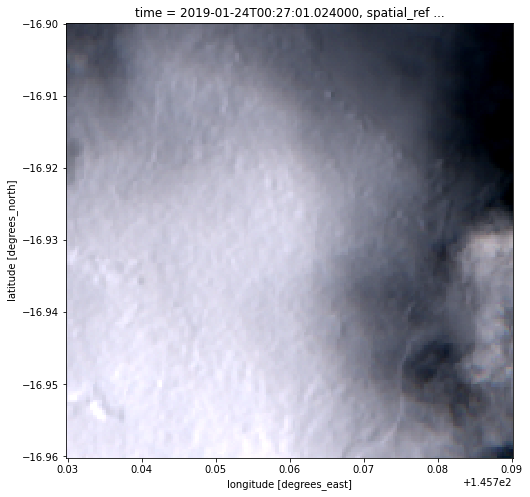

In [7]:
cairns[['nbart_red', 'nbart_green', 'nbart_blue']].isel(time=4).to_array().plot.imshow(robust=True, figsize=(8,8))

#### The Bureau of Meteorology offers historical daily precipitation information on its "Australian Landscape Water Balance" [website](http://www.bom.gov.au/water/landscape/)

#### Daily precipitation grids are produced by the Bureau from approximately 6,500 rain gauge stations and interpolated to a 0.05 degree (approximately 5 x 5 km) national grid.

#### These data can be downloaded but the servers where it is stored also offer a web service that can be accessed using XArray. Notice that here we are passing an http address to the `open_dataset` function instead of a path to a local file.

In [3]:
prec = xr.open_dataset("data/rain_day_2019.nc")
prec

<xarray.Dataset>
Dimensions:    (latitude: 681, longitude: 841, time: 365)
Coordinates:
  * time       (time) datetime64[ns] 2019-01-01 2019-01-02 ... 2019-12-31
  * latitude   (latitude) float64 -10.0 -10.05 -10.1 ... -43.9 -43.95 -44.0
  * longitude  (longitude) float64 112.0 112.0 112.1 112.2 ... 153.9 153.9 154.0
Data variables:
    rain_day   (time, latitude, longitude) float32 ...
Attributes:
    var_name:       rain_day
    title:          Australian Landscape Water Balance AWRA-L Model
    Description:    This data is provided by the Bureau of Meteorology and ca...
    summary:        Data produced by Bureau of Meteorology Australian Water R...
    source:         AWRA-L
    date_created:   2020-08-20T19:41:51
    Conventions:    CF-1.6, ACDD-1.3
    institution:    Bureau of Meteorology
    email:          awrams@bom.gov.au
    url:            http://www.bom.gov.au/water/landscape
    date_modified:  2020-08-20T19:43:05

#### At this point we have not requested any data from the BoM server, we have just read the headers information to fill out the XArray `Dataset` object. The `prec` object does not contain the gridded precipitation data yet, that is why this operation runs very fast.

#### Now we are going to narrow down our selection using the extents defined in the DEA `cairns` Dataset. First we perform the selection spatially and then temporally. Notice the `method=nearest` parameter in the temporal selection, which we have to use to match closest dates as each Dataset contains different dates.

In [11]:
cairns.latitude[-1]

<xarray.DataArray 'latitude' ()>
array(-16.96005)
Coordinates:
    latitude     float64 -16.96
    spatial_ref  int32 4326
Attributes:
    units:       degrees_north
    resolution:  -0.0003
    crs:         EPSG:4326

In [12]:
# First we perform a spatial selection using the extents of sentinel Dataset
prec = prec.sel(latitude=slice(cairns.latitude[0],cairns.latitude[-1]), longitude=slice(cairns.longitude[0],cairns.longitude[-1]))

prec

<xarray.Dataset>
Dimensions:    (latitude: 1, longitude: 1, time: 365)
Coordinates:
  * time       (time) datetime64[ns] 2019-01-01 2019-01-02 ... 2019-12-31
  * latitude   (latitude) float64 -16.95
  * longitude  (longitude) float64 145.8
Data variables:
    rain_day   (time, latitude, longitude) float32 ...
Attributes:
    var_name:       rain_day
    title:          Australian Landscape Water Balance AWRA-L Model
    Description:    This data is provided by the Bureau of Meteorology and ca...
    summary:        Data produced by Bureau of Meteorology Australian Water R...
    source:         AWRA-L
    date_created:   2020-08-20T19:41:51
    Conventions:    CF-1.6, ACDD-1.3
    institution:    Bureau of Meteorology
    email:          awrams@bom.gov.au
    url:            http://www.bom.gov.au/water/landscape
    date_modified:  2020-08-20T19:43:05

In [13]:
# Then we select the dates that intersect with the sentinel Dataset
prec = prec.sel(time=cairns.time, method='nearest')

prec

<xarray.Dataset>
Dimensions:      (latitude: 1, longitude: 1, time: 12)
Coordinates:
  * time         (time) datetime64[ns] 2019-01-04 2019-01-07 ... 2019-02-26
  * latitude     (latitude) float64 -16.95
  * longitude    (longitude) float64 145.8
    spatial_ref  int32 4326
Data variables:
    rain_day     (time, latitude, longitude) float32 0.3984375 0.296875 ... 1.5
Attributes:
    var_name:       rain_day
    title:          Australian Landscape Water Balance AWRA-L Model
    Description:    This data is provided by the Bureau of Meteorology and ca...
    summary:        Data produced by Bureau of Meteorology Australian Water R...
    source:         AWRA-L
    date_created:   2020-08-20T19:41:51
    Conventions:    CF-1.6, ACDD-1.3
    institution:    Bureau of Meteorology
    email:          awrams@bom.gov.au
    url:            http://www.bom.gov.au/water/landscape
    date_modified:  2020-08-20T19:43:05

#### Due to the difference in spatial resolutions on both datasets the resulting precipitation Dataset contains just 1 pixel spatially. We can interrogate the contents of this Dataset by plotting the contents of the `rain_day` variable. Notice that we are now for the first time going to request the array data to the server, but by now we have reduced the amount of data to 12 pixels, so it is a very light and fast operation.

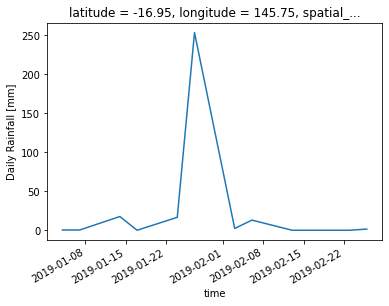

In [14]:
prec.rain_day.plot()

#### Let's define the threshold of 1 mm to consider what is a rainy day and use this threshold to classify our days as rainy. Notice how we use the Numpy `flatten()` function to get rid of the extra dimensions of the data and get a 1-dimensional flat array.

In [15]:
prec.rain_day

<xarray.DataArray 'rain_day' (time: 12, latitude: 1, longitude: 1)>
array([[[  0.398438]],

       [[  0.296875]],

       [[ 17.601562]],

       [[  0.      ]],

       [[ 16.601562]],

       [[253.20312 ]],

       [[  2.296875]],

       [[ 13.      ]],

       [[  0.      ]],

       [[  0.      ]],

       [[  0.      ]],

       [[  1.5     ]]], dtype=float32)
Coordinates:
  * time         (time) datetime64[ns] 2019-01-04 2019-01-07 ... 2019-02-26
  * latitude     (latitude) float64 -16.95
  * longitude    (longitude) float64 145.8
    spatial_ref  int32 4326
Attributes:
    name:           rain_day
    standard_name:  lwe_thickness_of_precipitation_amount
    long_name:      Daily Rainfall
    units:          mm

In [16]:
rainy = (prec.rain_day.values.flatten() > 1)

rainy

array([False, False,  True, False,  True,  True,  True,  True, False,
       False, False,  True])

#### Now let's have a quick look at the sequence of satellite images of Cairns.

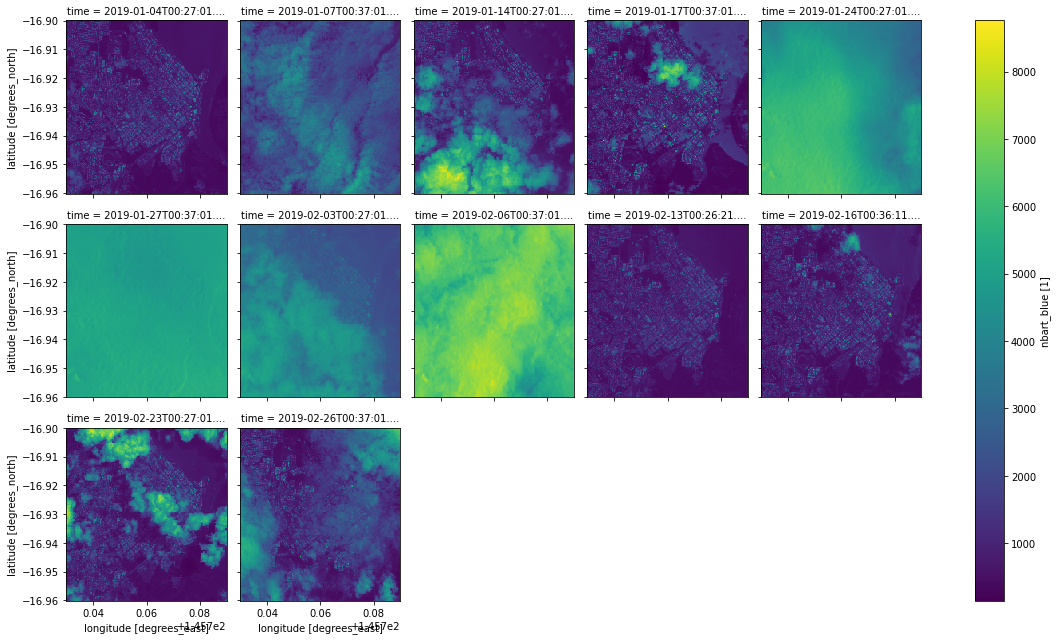

In [17]:
cairns.nbart_blue.plot(col='time', col_wrap=5)

#### There are some quite cloudy images that we might be able to detect using the precipitation data. Let's repeat this plot again using the BoM data to filter out the rainy days:

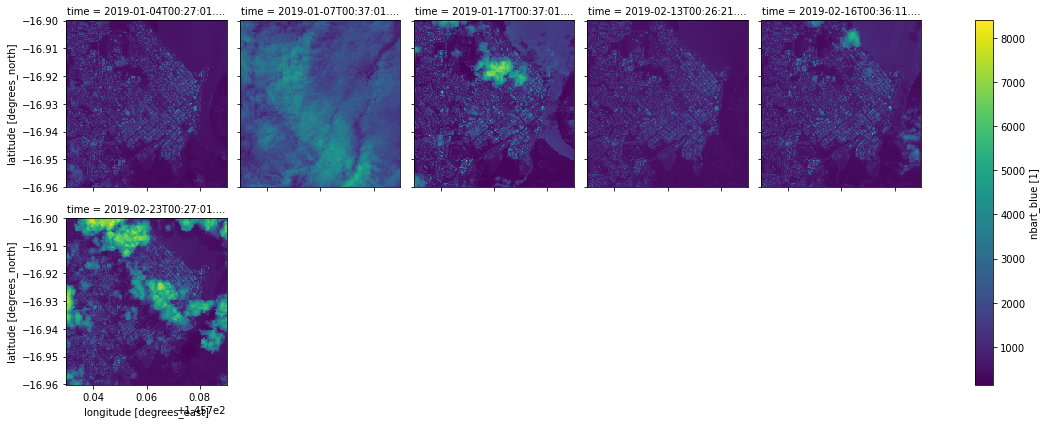

In [18]:
cairns.isel(time=~rainy).nbart_blue.plot(col='time', col_wrap=5)

#### Not bad! There are still some cloudy dry days in Cairns but we've removed most of the bad images.

#### Cairns has a tropical monsoon climate, which means that most of its precipitation happens in the summer season and it's due to convective storms. Melbourne, on the other hand use to have precipitation associated to frontal systems that come western low pressure systems. 

#### Exercise 7.1: Could you try to assess how this methodology would works in Melbourne?

> Note: Use some period in 2019 so you can use the same file for the precipitation

In [19]:
from osgeo import gdal

In [20]:
import rasterio